In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Wed Jul 22 20:58:50 PDT 2020


# Sketch of approach to producing correlation between birth weight and child growth failure


1. Initialize BW/GA risk factor exposure
2. Find BW percentile
3. Use BW percentile and specified correlation to find HAZ and WHZ percentiles
3. Initialize HAZ and WHZ risk factor exposures

In [2]:
### 1. Initialize birth weight and gestational age attributes for a new simulant
###
### This is already done acceptably, although we are supposed to document how it
### works more clearly.
###
### For this notebook, I'll just simulate something close enough

def initialize_bwga(size):
    return pd.DataFrame({
                'birth_weight':np.random.uniform(2500, 3500, size),
                'gestation_time': np.random.uniform(35, 40, size)
                   })
pop = initialize_bwga(1_000)
pop

,birth_weight,gestation_time
0,3441.168127,38.378658
1,3269.610372,39.669186
2,2523.499470,37.572474
3,2863.118663,38.259862
...,...,...
996,2913.313801,38.899077
997,3482.568591,35.230923
998,3049.066484,35.379259
999,2733.068280,38.497349


In [3]:
### 2. Find the percentile of birth_weight
###
### I propose that we do this empirically, although I am open to
### alternatives, so please let me know if there is a better way

bw_samples = initialize_bwga(100_000).birth_weight  # generate many samples from the birth_weight distribution
def empirical_percentile(x, samples):
    return np.mean(x >= samples)

pop['birth_weight_percentile'] = pop.birth_weight.apply(empirical_percentile, samples=bw_samples)

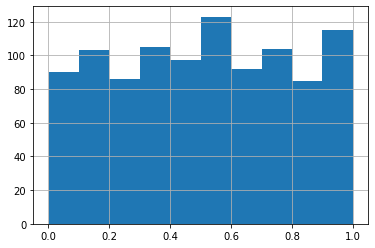

In [4]:
pop.birth_weight_percentile.hist();

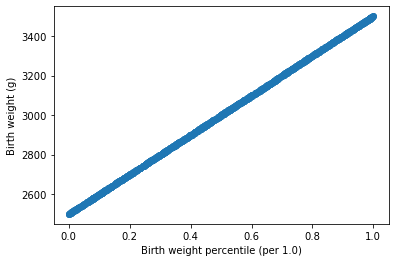

In [5]:
### pop.birth_weight_percentile should be uniformly distributed between 0 and 1
### and perfectly correlated with pop.birth_weight
plt.plot(pop.birth_weight_percentile, pop.birth_weight, 'o')
plt.xlabel('Birth weight percentile (per 1.0)')
plt.ylabel('Birth weight (g)');

## Use BW percentile and specified correlation to find HAZ and WHZ percentiles

1. probit transform birth weight percentile to get birth weight normal
2. sample conditional bivariate normal for HAZ normal (conditional on BW normal, with specified correlation
3. inverse probit transform HAZ normal to get HAZ percentile (aka "propensity")

Repeat (2) and (3) for WHZ.

In [6]:
import scipy.stats

In [7]:
pop['birth_weight_probit'] = scipy.stats.norm.ppf(pop.birth_weight_percentile)

In [8]:
def conditional_bivariate_normal(a, rho):
    # https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case_2    # with mu1 = mu2 = 0 and sigma1 = sigma2 = 1
    return np.random.normal(rho*a, np.sqrt((1-rho**2)))
pop['haz_probit'] = conditional_bivariate_normal(pop.birth_weight_probit, 0.3)
pop['haz_percentile'] = scipy.stats.norm.cdf(pop.haz_probit)

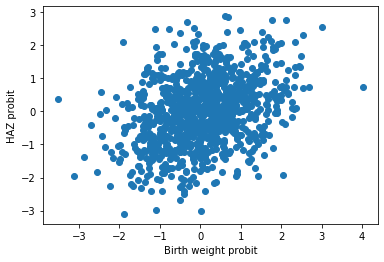

In [9]:
### pop.birth_weight_probit and pop.haz_probit should be obviously correlated
plt.plot(pop.birth_weight_probit, pop.haz_probit, 'o')
plt.xlabel('Birth weight probit')
plt.ylabel('HAZ probit');

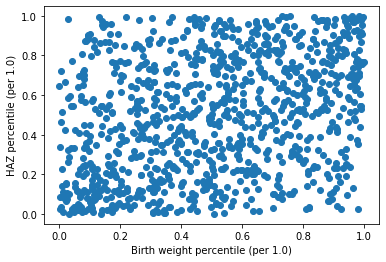

In [10]:
### pop.birth_weight_percentile and pop.haz_percentile should be correlated, too,
### although perhaps harder to see
plt.plot(pop.birth_weight_percentile, pop.haz_percentile, 'o')
plt.xlabel('Birth weight percentile (per 1.0)')
plt.ylabel('HAZ percentile (per 1.0)');

In [11]:
# recall that our goal was to produce correlation of 0.3

import scipy.stats
scipy.stats.spearmanr(pop.birth_weight_percentile, pop.haz_percentile)

SpearmanrResult(correlation=0.3247255123123373, pvalue=5.478417183757087e-26)

In [12]:
pop['whz_probit'] = conditional_bivariate_normal(pop.birth_weight_probit, 0.4)  # check with Nicole to get the correct values
pop['whz_percentile'] = scipy.stats.norm.cdf(pop.whz_probit)

In [13]:
scipy.stats.spearmanr(pop.birth_weight_percentile, pop.whz_percentile)

SpearmanrResult(correlation=0.3930543279209362, pvalue=2.737075244861103e-38)

In [14]:
### note: correlation of haz and whz both with birth_weight
### induces correlation between haz and whz
scipy.stats.spearmanr(pop.whz_percentile, pop.haz_percentile)

SpearmanrResult(correlation=0.13094599094599096, pvalue=3.272945649516962e-05)

In [15]:
# 3. Initialize HAZ and WHZ risk factor exposures

# since we have come up with percentiles for them, this can
# proceed as it is already implemented in vivarium_public_health